# Busqueda de un decaimiento de partículas mediante análisis de datos

A partir de una señal generada por simulación de Monte Carlo, se busca comparar con una serie de señales de ruido llamadas background. El objetivo es superponer la simulación con los distintos datos que se pueden dar en la realidad, mediante la aplicación de arboles de decisión o BDT (por sus siglas en inglés) se busca obtener la mejor señal posible con la menor perdida de datos y la mayor limpieza de ruido (background).
Finalmente, utilizando el criterio de Punzi, seleccionamos el corte más eficiente entre los datos seleccionados por el BDT, para así concluir con la señal más eficiente.

In [1]:
import root_pandas
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from ROOT import TChain
from ROOT import TFile, TCanvas, TPad, TChain, TLegend, TH1D
from array import array
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Welcome to JupyROOT 6.24/00


In /home/diego/.config/matplotlib/stylelib/belle2_serif.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/diego/.config/matplotlib/stylelib/belle2_serif.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/diego/.config/matplotlib/stylelib/belle2_serif.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/diego/.config/matplotlib/stylelib/belle2.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/diego/.config/matplotlib/stylelib/belle2.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead

# Se inician cargando los datos mediante root pandas

In [2]:
# Primero el dato de señal generada por Monte Carlo
chtauLNV = root_pandas.read_root("tau2pill.root", "tau3x1piee")

#Luego los distintos ruidos obtenidos en el colisionador de partículas BELLE II en Japón.
chtaupair = root_pandas.read_root("tau2pill_taupair_100fb_all.root", "tau3x1piee")
chmumu = root_pandas.read_root("tau2pill_mumu_100fb_all.root", "tau3x1piee")
cheeee = root_pandas.read_root("tau2pill_eeee_100fb_all.root", "tau3x1piee")

# ROOT CERN

No todos los archivos son soportados por root_pandas, por lo cual se utiliza a continuación ROOT, el cuál es un framework de análisis de datos científicos a gran escala. Este framework trabaja en lenguaje C++.

In [3]:
chee = TChain("tau3x1piee")
chee.AddFile("tau2pill_ee_100fb_all.root")
chee1 = []
# Se organizan los datos para ser utilizados en un histograma
for i in range(chee.GetEntries()):     
    chee.GetEntry(i)
    a = chee.GetLeaf("tau_3prong_InvM").GetValue()
    chee1.append(a)

cheeInvMass = np.asarray(chee1)

#  Histograma

A continuación, se distingue entre la señal y los diferentes ruidos, lo cual permite magnificar la necesidad de hacer una selección adecuada de los datos para obtener solo señal util.
Para este caso, utilizamos la masa invariante de las partículas analizadas (señal y ruido), pueden darse otros casos donde utilicemos otras cantindades físicas pero la más conveniente es la masa invariante.

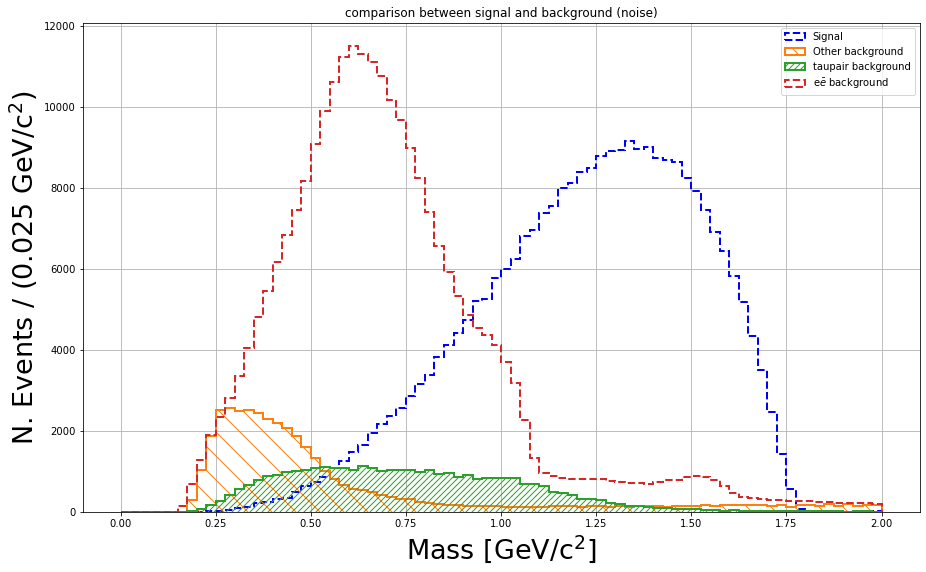

In [4]:
plt.figure(figsize=(15, 9))
# Datos con pandas
hchtauLNV = chtauLNV["tau_3prong_InvM"]
hchtaupair = chtaupair["tau_3prong_InvM"]
hcheeee = cheeee["tau_3prong_InvM"]
hchmumu = chmumu["tau_3prong_InvM"]
# Dato cargado con ROOT
# Se reescala la señal de ruido ee dado que es muy grande y no se alcanzaría a ver su influencia sobre la señal
# principal
hchee_w = np.empty(cheeInvMass.shape)
hchee_w.fill(1/cheeInvMass.shape[0])
# unificamos los ruidos eeee y mumu en uno solo dado que su influencia es similar
hchotrosbkg = np.concatenate((hcheeee, hchmumu)) 
# se aplican los histogramas con distintas modificaciones para poder analizar diferencias
plt.hist(hchtauLNV, 80 , label = "Signal", range = (0., 2.0), linestyle = 'dashed', histtype = 'step', linewidth = 2, facecolor = '#2CBDFE', lw = 2, edgecolor = 'b')
plt.hist(hchotrosbkg, 80,  label = 'Other background', range = (0., 2.0), histtype = 'step', hatch = '\\', facecolor = 'k', linewidth = 2)
plt.hist(hchtaupair, 80, label = 'taupair background', range = (0., 2.0), histtype = 'step', linewidth = 2, hatch= '////', lw = 2)
plt.hist(cheeInvMass, 80, weights = hchee_w*260000, label = r'e$\bar{e}$ background', range = (0., 2.0), histtype = 'step', linewidth = 2, lw = 2, linestyle = 'dashed')


plt.xlabel("Mass [GeV/$\mathrm{c}^2$]",fontsize = 27)
plt.ylabel(r"N. Events / (0.025 GeV/$\mathrm{c}^2$)",fontsize = 27)
plt.title("comparison between signal and background (noise)")
plt.legend(loc='upper right')
plt.grid()
plt.savefig('SignalofMass.png')
plt.show()

#  Análisis mediante árboles de decisión

Para poder separar entre los datos de señal y ruido que mejor podemos aprovechar, aplicamos un BDT. Este método de Machine learning, asigna un valor binario a los datos dependiendo si se deben descartar o no. 
Para su utilización, primero debemos utilizarlo en un conjunto de datos que serán utilizados como datos de entrenamiento, para posteriormente aplicarlo a los datos restantes y obtener el mejor conjunto de datos a separar entre señal y ruido.

In [5]:
# Subimos todos los demás datos en ROOT
# Señal
chtauLNV = TChain("tau3x1piee")
# Background
chtaupair = TChain("tau3x1piee")
ch4e = TChain("tau3x1piee")
ch2mu = TChain("tau3x1piee")

# Señal
chtauLNV.AddFile("tau2pill.root")
# Background
chtaupair.AddFile("tau2pill_taupair_100fb_all.root")
ch4e.AddFile("tau2pill_eeee_100fb_all.root")
ch2mu.AddFile("tau2pill_mumu_100fb_all.root")

1

# Funciones de cortes y  toma de datos

Previo al análisis con BDT se crean dos funciones, la primera sirve para aplicar unos cortes estándar de la física de partículas que descartan cantidades no reales o innecesarias de los datos. Por otra parte, se crea una función que esta encargada de recolectar los datos y reducir lineas de código repetitivas.

In [6]:
# Función con algunos cortes, para descartar partículas con las siguientes cantidades negativas

def passCuts(chain, event):
    
    accepted = False
    chain.GetEntry(event) #chtauLNV.GetEntry() # número de byts en chtauLNV
    
    if chain.tau_3prong_chiProb <=0:
        return accepted
    if chain.track1_3prong_EoverP <=0:
        return accepted
    if chain.track2_3prong_EoverP <=0:
        return accepted
    if chain.track3_3prong_EoverP <=0:
        return accepted
    
    accepted = True
    return accepted

In [7]:
def getData(chain, leaf, npoints, option):
    # chain : Root TChain que almacena los datos
    # leaf : arreglo que contiene las variables que serán usadas por chain
    # npoints : numero de eventos que se analizan en chain
    # option : sea 'random' ó 'secuencial' selección de npuntos
    data = []
    totalpoints = chain.GetEntries()
    nentries = npoints
    if npoints > totalpoints:
        print("** Points requested greater than the number of points in the chain")
        print("** Taking all points in the chain : ", totalpoints)
        nentries = totalpoints
    
    if option != 'sequential' and option != 'random' and option != 'all':
        print("** 'option' should be either all, sequential or random")
        print("** Taking option = sequential")
        option = 'sequential'
    nsampling = np.empty(nentries) # crea un array con el tamaño de nentries
    
    if option == 'all':
        nsampling = [ i for i in range(totalpoints)]
        
    if option == 'sequential':
        nsampling = [i for i in range(nentries)]
        
    if option == 'random':
        nsampling = random.sample(range(0, totalpoints), nentries) # toma numeros aleatorios de la lista
        nsampling.sort() # organiza en orden ascendente la lista   # de 0 a totalpoints de cantidad 'nentries'
        
    for k in nsampling:
        accepted = passCuts(chain, k)
        if accepted == False:
            continue
            
        event = [0]*len(leaf)         # genera un vector de ceros con longitud 'len(leaf)'
        for i in range(len(leaf)):
            event[i] = chain.GetLeaf(leaf[i]).GetValue()
         
        if accepted == True:
            data.append(event)
        
    return data

#
Los datos cargados, se dividen en varias secciones y subsecciones, un ejemplo de subsección es la masa invariante que vamos a analizar, el BDT se mejora mediante distintas variables como esta para arrojar el mejor resultado. Es por esto que se toman las siguientes variables contenidas en los archivos de datos.

In [8]:
leafbdt = ["thrust", "visibleEnergyOfEventCMS","missingMomentumOfEventCMS",
           "missingMomentumOfEventCMS_theta", "tau_3prong_dr", 
           "sumCos3prong", "missingMass2OfEvent", "track1_3prong_EoverP",
           "track2_3prong_EoverP", "track3_3prong_EoverP"]

In [9]:
# Se toman 1/2 de eventos aleatoreos de cada muestra sgn & bkg para el entrenamiento

dSig = getData(chtauLNV, leafbdt, int(chtauLNV.GetEntries()/2), "random")

In [10]:
dtau = getData(chtaupair, leafbdt, int(chtaupair.GetEntries()/2), "random")
dee = getData(chee,leafbdt,int(chee.GetEntries()/2),"random")


In [11]:
d4e = getData(ch4e,leafbdt,int(ch4e.GetEntries()/2),"random")
d2mu = getData(ch2mu,leafbdt,int(ch2mu.GetEntries()/2),"random")

In [12]:
dbkg = dtau+dee+d4e+d2mu

In [13]:
# Se prepara los datos para hacer el BDT

bdtDataS = np.asarray(dSig)
bdtDataB = np.asarray(dbkg)

category_S = [1]*len(bdtDataS)
category_B = [0]*len(bdtDataB)

cat_S = np.asarray(category_S)
cat_B = np.asarray(category_B)

X = np.concatenate((bdtDataS, bdtDataB))
y = np.concatenate((cat_S, cat_B))

In [14]:
# Se crea y ajusta un Arbol de decisiones BDT
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm = "SAMME", n_estimators = 200)

bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=200)

In [15]:
bdtValS = bdt.decision_function(bdtDataS) # Se calculan los bdt para la variable 'bdtDataS'
bdtValB = bdt.decision_function(bdtDataB) # ""    " "           " "               'bdtDataB'

In [16]:
hbdtS = TH1D("hbdtS", "Signal; BDT Response; Entries (1/N)", 50, -1, 1)
hbdtB = TH1D("hbtB", "Background", 50, -1, 1)

In [17]:
for i in range(len(bdtValS)):
    hbdtS.Fill(bdtValS[i])
for i in range(len(bdtValB)):
    hbdtB.Fill(bdtValB[i])

#  BDT
Se procede a graficar la mejor separación obtenida

Info in <TCanvas::Print>: png file separacionbdt.png has been created


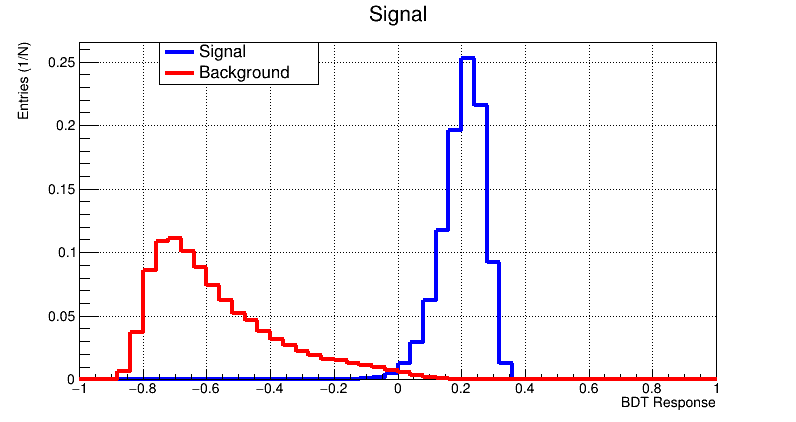

In [18]:
hbdtS.Scale(1/hbdtS.GetEntries())
hbdtB.Scale(1/hbdtB.GetEntries())

hbdtS.SetStats(0)
hbdtB.SetStats(0)

hbdtS.SetLineColor(kBlue)
hbdtB.SetLineColor(kRed)

labelbdt = TLegend(.2, .9, .4, .8);
labelbdt.AddEntry(hbdtS, "Signal", "l")
labelbdt.AddEntry(hbdtB, "Background", "l")

cBDT = TCanvas("cBDT", "", 800, 450)

cBDT.SetGrid()
hbdtB.SetYTitle("Entries 1/N ")
hbdtB.GetYaxis().CenterTitle()

cBDT.cd()
hbdtS.SetFillStyle(4050)
hbdtB.SetFillStyle(3004)

hbdtS.Draw("HIST")
hbdtB.Draw("HIST same")

hbdtS.SetLineWidth(4)
hbdtB.SetLineWidth(4)

labelbdt.Draw()
cBDT.Draw()


cBDT.SaveAs("separacionbdt.png")

#  Criterio de separación más eficiente de Punzi
Separados los datos mediante el BDT, es más óptimo hacer un corte en este resultado mediante un método que busque el corte más eficiente, en este caso utilizamos el criterio de Punzi que cumple con: 

$\hspace{8cm}\frac{\epsilon}{a/2+\sqrt{B}}$ 

En donde $\epsilon$ es la eficiencia de datos obtenidos, $a$ es el valor de confianza y B es el ruido.
Este método es muy útil para casos de predicción en los que no se cuenta con mucha información de lo buscado.

In [19]:
leafsall = ["thrust","visibleEnergyOfEventCMS","missingMomentumOfEventCMS",
            "missingMomentumOfEventCMS_theta","tau_3prong_dr",
            "sumCos3prong","missingMass2OfEvent","track1_3prong_EoverP",
            "track2_3prong_EoverP","track3_3prong_EoverP","tau_3prong_InvM"]

In [20]:
dSigD = getData(chtauLNV,leafsall, int(chtauLNV.GetEntries()/2), "all")

In [21]:
dtauD = getData(chtaupair, leafsall, int(chtaupair.GetEntries()/2), "all")
deeD = getData(chee,leafsall,int(chee.GetEntries()/2),"all")

In [22]:
d4eD = getData(ch4e,leafsall,int(ch4e.GetEntries()/2),"all")
d2muD = getData(ch2mu,leafsall,int(ch2mu.GetEntries()/2),"all")

In [23]:
dbkgD = dtauD+deeD+d4eD+d2muD

In [24]:
dataS = np.asarray(dSigD)
dataB = np.asarray(dbkgD)

In [25]:
bdtS = bdt.decision_function(dataS[:,:10]) # Toma todos los datos de las 5 entradas de leaf
bdtB = bdt.decision_function(dataB[:,:10])

maximum at x =  0.21600000000000003


Info in <TCanvas::Print>: png file criteriopunzi.png has been created


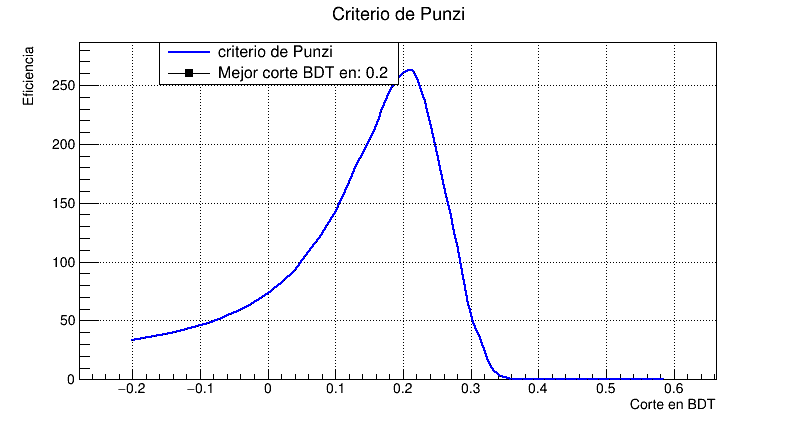

In [26]:
# Significancia de Punzi

bdtmax = 0.6
bdtmin = -0.2
nbins = 50
binsize = (bdtmax - bdtmin)/nbins        # Ancho de los bines del histograma

psampling = [bdtmin+i*binsize for i in range(nbins)]

dSigBdt = np.reshape(dataS,(len(dataS),-1)) # Reordena a 'dataS' con numero de filas 'len(dataS)' y columns '-1' 
dBkgBdt = np.reshape(dataB,(len(dataB),-1)) 

#dBkgBdt2 = np.reshape(dataB2,(len(dataB2),-1))
#print(dBkgBdt1)
#dBkgBdt = np.concatenate((dBkgBdt1,dBkgBdt2))

bdtSC = np.reshape(bdtS,(len(bdtS),-1)) # Reordena bdtS con número de filas 'len(bdtS)' y columnas '-1'
bdtBC = np.reshape(bdtB,(len(bdtB),-1))

dSigBdt = np.append(dSigBdt,bdtSC,axis=1)  # Añade a 'dSigBdt' los datos del eje 1 de 'bdtSC'
dBkgBdt = np.append(dBkgBdt,bdtBC,axis=1)

ngenSig = 500000  # la mitad de los datos son tomados, la otra mitad fue en entrenamiento

apar = 5        # Desviación estándar de 5 sigma con un nivel de confianza del 99,9999426697 % 
Amp = 10000   

x ,y = array('d'),array('d')

for i in range(len(psampling)):
    nbkg = len([x for x in dBkgBdt if x[11]>psampling[i]])
    nsig = len([x for x in dSigBdt if x[11]>psampling[i]])
    eff = nsig/ngenSig
    punzi =eff/( apar/2 + np.sqrt(nbkg))
    x.append(psampling[i])
    y.append(Amp*punzi)
    #print(psampling[i]," ",nbkg," ", nsig," ",eff," ",punzi)

#Let's find the maximum
ymaxval = np.amax(y)
x_at_max_array = np.where(y==np.amax(y))
x_at_max = x[int(x_at_max_array[0])]
print("maximum at x = ",x_at_max)

gFOM = TGraph(len(psampling),x,y)

gFOM.SetLineColor(kBlue)
gFOM.SetLineWidth(2)

labelgFOM = TLegend(.2, .9, .5, .8);
labelgFOM.AddEntry(gFOM, "criterio de Punzi", "l")
labelgFOM.AddEntry("", "Mejor corte BDT en: 0.2")

cP = TCanvas("cP", "", 800, 450)
cP.SetGrid()
cP.cd()

gFOM.SetTitle("Criterio de Punzi; Corte en BDT; Eficiencia ")
#gFOM.GetYaxis.SetTitle("Eficiencia")

gFOM.Draw("ACP")
labelgFOM.Draw()
cP.Draw()


cP.SaveAs("criteriopunzi.png")

# Señal final
Finalmente obtenemos la señal buscada con el menor ruido y eficiencia posible.

Signal efficiency epsilon:  20.3108 %


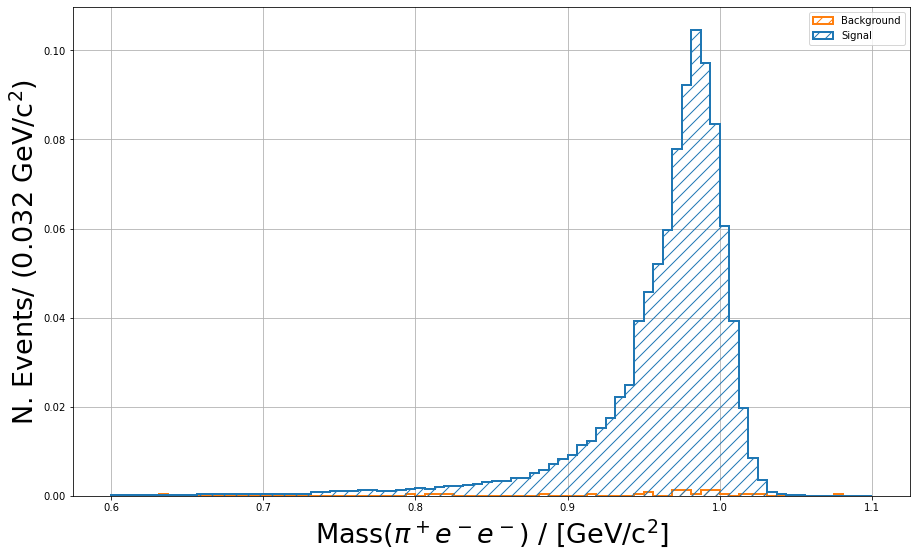

In [28]:
InvMassSig = []
InvMassBkg = []

bdtcut = x_at_max

for i in range(len(bdtS)):
    if bdtS[i]>bdtcut:
        S = dataS[i][9]
        InvMassSig.append(S)

for i in range(len(bdtB)):
    if bdtB[i]>bdtcut:
        B = dataB[i][9]
        InvMassBkg.append(B)

finalSig = len(InvMassSig)
finalBakg = len(InvMassBkg)

print(r"Signal efficiency epsilon: ", 100*finalSig/ngenSig, "%")

InvMassSig_w = np.empty(np.asarray(InvMassSig).shape)
InvMassBkg_w = np.empty(np.asarray(InvMassBkg).shape)

if finalBakg !=0:
    InvMassSig_w.fill(1/np.asarray(InvMassSig).shape[0])
    InvMassBkg_w.fill(50.0*1/np.asarray(InvMassSig).shape[0])
else:
    print("Zero events remaining in background sample")
    
plt.figure(figsize=(15,9))

plt.hist([InvMassSig, InvMassBkg], weights = [InvMassSig_w, InvMassBkg_w], bins = 80, range = (0.6, 1.1), label = ['Signal', 'Background'], hatch = '//', histtype = 'step', lw =2)

plt.xlabel(r"Mass$(\pi^+e^-e^-)$ / [GeV/$\mathrm{c}^2$]",fontsize = 27);
plt.ylabel("N. Events/ (0.032 GeV/$\mathrm{c}^2$)",fontsize = 27)
plt.legend(loc='upper right')
plt.grid()
plt.savefig('InvariantMassLNV_BDT.png')
plt.show()